## Simple Active Learn

This notebook shows a very simple implementation of active learn.

Active learn is a technique that can enable data scientist to generate a labeled dataset from an unlabeled one easier than labeling it completely.
There is labeling involved, but this process uses a model to identify the best samples to annotate reducing the time that it takes and providing immediate feedback on when the dataset is good enough.

Active Learn can be splitted into 3 steps.
* 1: Seeding
* 2: Similarity
* 3: Iteration

On 1, we provide seeds (i.e. samples of each class) to identify potentially easy datapoints.
Then, we do a similarity search on the dataset and present other similar samples that could be also used as starting points.
Finally, we iterate by training a model with the current dataset, making predictions in the unlabeled dataset, and the best samples to annotate next. This last step can be repeated until we are pleased with the metrics.

It is important to note, that though the first two steps are not strictly necessary and one can jump right to the iteration, providing seeds helps the model to find the right samples sooner and could save precious time.

# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import numpy as np
from ipyannotations.generic import ClassLabeller
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### Load dataset

For this experiment, are going to use the IMDB reviews sentiment dataset, and though we have the actual label, only the review column will be used. 

We'll generate the labels using Active Learn

The reason for keeping a dataset with labels in here, is so we can later compare a model generated through active learn vs a model generated with all the labels from the beginning.

For this, we are doing an 80-20 split of the dataset.

In [2]:
dataset = pd.read_csv('./../data/IMDB Dataset.csv')

In [3]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
dataset['len'] = dataset.apply(lambda x: len(x.review.split(" ")), axis=1)
dataset = dataset[dataset["len"] < 300]
# dataset['len'] = dataset.apply(lambda x: len(x.review), axis=1)

In [5]:
dataset.describe()

,len
count,38778.000000
mean,157.007582
std,61.085023
min,4.000000
25%,118.000000
50%,148.000000
75%,197.000000
max,299.000000


<AxesSubplot: >

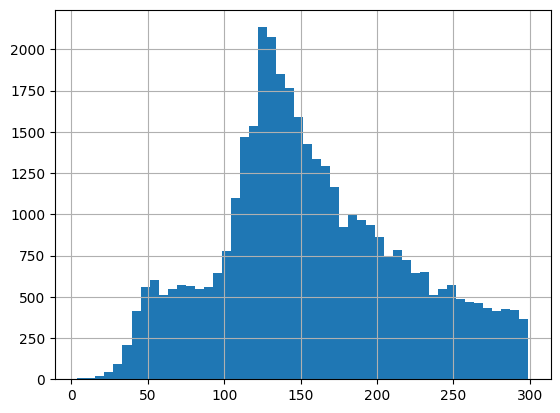

In [6]:
dataset["len"].hist(bins=50)

In [7]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

In [8]:
al_dataset = train_dataset[['review']]
al_dataset.reset_index(inplace=True, drop=True)

In [9]:
train_dataset.head()

,review,sentiment,len
34568,"with a title like this, you know not to expect...",negative,170
17938,So what's the big fuss out of making an INDIAN...,negative,122
15827,Horrendous pillaging of a classic.<br /><br />...,negative,190
565,"I don't normally write reviews, but this ""film...",negative,232
28581,Think Jumanji but with a death curse. A bunch ...,negative,120


In [10]:
al_dataset.head()

,review
0,"with a title like this, you know not to expect..."
1,So what's the big fuss out of making an INDIAN...
2,Horrendous pillaging of a classic.<br /><br />...
3,"I don't normally write reviews, but this ""film..."
4,Think Jumanji but with a death curse. A bunch ...


In [11]:
test_dataset = test_dataset.rename(columns={'sentiment':'label'})

### Seeds

What is very insteresting about seeds, is that they don't really need to be part of the dataset. Though in many scenarios it'd be easier to just go to the dataset and pick a few examples, here we already know what good and bad reviews are, so we can just come up with a few examples.

In [12]:
good_reviews_seeds = [
    """One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.""",
    """A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.""",
    """I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends."""
]

In [13]:
bad_reviews_seeds = [
    """Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.""",
    """This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air.""",
    """I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday afternoons, I still was tired of the formula for these monster type movies that usually included the hero, a beautiful woman who might be the daughter of a professor and a happy resolution when the monster died in the end. I didn't care much for the romantic angle as a 12 year old and the predictable plots. I love them now for the unintentional humor.<br /><br />But, about a year or so later, I saw Psycho when it came out and I loved that the star, Janet Leigh, was bumped off early in the film. I sat up and took notice at that point. Since screenwriters are making up the story, make it up to be as scary as possible and not from a well-worn formula. There are no rules."""
]

### Similarity

Once we have the seeds, now we can find similar samples in our corpus to start the labelling process.

Based on the problem, this is a point where we can get very creative or keep it simple. We are going for the second option here.

For each seed, we'll get two similar reviews

In [15]:
# vectorizer = HashingVectorizer(n_features=600,ngram_range=(1,6),lowercase=False,analyzer='char_wb')
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(al_dataset.review.tolist())

TfidfVectorizer(max_features=10000)

In [16]:
# good_vectors = vectorizer.fit_transform(good_reviews_seeds).todense()
good_vectors = vectorizer.transform(good_reviews_seeds).todense()

In [17]:
# bad_vectors = vectorizer.fit_transform(bad_reviews_seeds).todense()
bad_vectors = vectorizer.transform(bad_reviews_seeds).todense()

In [18]:
# reviews_vectors = vectorizer.fit_transform(al_dataset.review.tolist()).todense()
reviews_vectors = vectorizer.transform(al_dataset.review.tolist()).todense()

In [19]:
good_vectors.shape

(3, 10000)

In [20]:
reviews_vectors.shape

(31022, 10000)

In [21]:
NUM_SAMPLES = 2

# Calculate cosine distance (opposite to cosine similarity)
good_distances = scipy.spatial.distance.cdist(good_vectors, reviews_vectors, metric='cosine')
bad_distances = scipy.spatial.distance.cdist(bad_vectors, reviews_vectors, metric='cosine')

# Sort in ascending order and pick the first 10 of each
closest_k_good = np.argsort(good_distances)[:, :NUM_SAMPLES].flatten()
closest_k_bad = np.argsort(bad_distances)[:, :NUM_SAMPLES].flatten()

good_to_label_idxs = list(set(list(closest_k_good)))
bad_to_label_idxs = list(set(list(closest_k_bad)))

## Annotate first samples

Once we get the first samples from similarity matching, we can annotate them. 

Hopefully we can get examples from both classes. If that is not the case, then we should probably increase the number of samples per seed.

In [22]:
import IPython.display

def display_text(ix):
    print('Review:')
    display(al_dataset.iloc[ix].review)

In [23]:
import pigeonXT as pixt

annotations = pixt.annotate(
    good_to_label_idxs + bad_to_label_idxs,
    options=['positive', 'negative'],
    display_fn=display_text,
    buttons_in_a_row=2
)

HTML(value='0 of 12 Examples annotated, Current Position: 0 ')

Output()

Annotation done.


In [84]:
annotations

,example,changed,label
0,19991,True,negative
1,14343,True,positive
2,4966,True,positive
3,30403,True,positive
4,17123,True,positive
5,3311,True,positive
6,148,True,negative
7,29008,True,negative
8,20768,True,positive
9,20647,True,positive


## Retrieve samples and remove them from the data pool

In [24]:
data_train = al_dataset.iloc[annotations.example.values]
data_train['label'] = annotations.label.values
data_train.reset_index(drop=True, inplace=True)
data_train

/var/folders/1r/hlm76d9d6r7058jg86msr16r0000gn/T/ipykernel_25173/1112712001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['label'] = annotations.label.values


,review,label
0,"One of the best TV shows out there, if not the...",positive
1,I thought this was a wonderful way to spend ti...,positive
2,I enjoyed The Night Listener very much. It's o...,positive
3,A wonderful little production. <br /><br />The...,positive
4,Great Woody Allen? No. Good Woody Allen? Defin...,positive
5,I admit that I almost gave up on watching TV s...,positive
6,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,"Now, I flicked onto this just out of curiosity...",negative
9,"Wow, I just saw this on T.V. as one of the ""sc...",negative


In [25]:
al_dataset = al_dataset.iloc[~al_dataset.index.isin(annotations.example.values)]
al_dataset.reset_index(inplace=True, drop=True)

## Create features

We should get the features from the training data and from the data pool so we can get the new samples from the trained model.

We need to pay special attention to the vectorizer as the data will be changing over time.

One option is to use a vectorizer that doesn't rely on a computed state like HashingVectorizer. Another option, what we are using here, is to fit another type of vectorizer at the begining on the pool dataset (which should be the largest dataset of both) and continue to use the same one throughout the process


In [26]:
def get_features(df, labels=False, vectorizer=None):
    if vectorizer:
        features = vectorizer.transform(df.review.values)
    else:
        vectorizer = TfidfVectorizer()
        features = vectorizer.fit_transform(df.review.values)
    
    if labels:
        y = df['label'].values
        return features, y, vectorizer
    else:
        return features, vectorizer

In [27]:
pool_features, vectorizer = get_features(al_dataset, labels=False, vectorizer=vectorizer)

In [28]:
train_features, labels, vectorizer = get_features(data_train, labels=True, vectorizer=vectorizer)

In [29]:
eval_features, eval_labels, vectorizer = get_features(test_dataset, labels=True, vectorizer=vectorizer)

## Create learner

Once we have the features and some data labeled, we are good to start training the initial learner.

We shouldn't expect a very good performance right from the start, but this learner will help us detect the samples from the data pool that would make the most sense to label next.

***

There are 3 pieces of information that the learner needs:
1) `estimator`: This is the model that will be trained. In our example, we are using scikit-learn's RandomForestClassifier
2) `query_strategy`: This is the strategy used to sample the next data points that we should label. In our case we are going with uncertainty sampling.
3) `X_training`: The initial training data

***

***Uncertainty sampling***

When predicting using a ML model, we usually get a confidence score alongside the prediction. If that confidence score is far from the ideal (i.e close to the threshold of prediction), we could say that the model is uncertain about that particular prediction.

In uncertainty sampling, we use such confidence score to calculate how uncertain the model is and use that to select the next samples

In [30]:
def classifier_uncertainty(classifier, X):

    # calculate uncertainty for each point provided
    classwise_uncertainty = classifier.estimator.predict_proba(X)
    
    # Ignore None labels to confirm and focus on actual labels
    prediction = classifier.predict(X)
    prediction = np.array([1 if p != 'None' else 0 for p in list(prediction) ])

    # for each point, select the maximum uncertainty
    uncertainty = 1 - np.max(classwise_uncertainty, axis=1)
    
    return uncertainty * prediction#A, uncertainty * predictionB 

In [64]:
classwise_uncertainty = learner.estimator.predict_proba(new_features)
classwise_uncertainty

array([[0.13, 0.87],
       [0.13, 0.87],
       [0.22, 0.78],
       [0.17, 0.83],
       [0.14, 0.86],
       [0.79, 0.21],
       [0.75, 0.25],
       [0.18, 0.82],
       [0.13, 0.87],
       [0.16, 0.84]])

In [65]:
prediction = learner.predict(new_features)
prediction

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'negative', 'positive', 'positive', 'positive'],
      dtype=object)

In [66]:
prediction = np.array([1 if p != 'None' else 0 for p in list(prediction) ])
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [67]:
uncertainty = 1 - np.max(classwise_uncertainty, axis=1)
uncertainty

array([0.13, 0.13, 0.22, 0.17, 0.14, 0.21, 0.25, 0.18, 0.13, 0.16])

In [69]:
uncertainty = uncertainty * prediction
uncertainty

array([0.13, 0.13, 0.22, 0.17, 0.14, 0.21, 0.25, 0.18, 0.13, 0.16])

In [70]:
from modAL.utils.selection import shuffled_argmax
sampling = shuffled_argmax(uncertainty, n_instances=10)
sampling

array([1, 0, 8, 4, 9, 3, 7, 5, 2, 6])

In [31]:
def uncertainty_sampling(classifier, X, n_instances = 10,  **uncertainty_measure_kwargs):
    from modAL.utils.selection import shuffled_argmax
    uncertainty  = classifier_uncertainty(classifier, X)
    return shuffled_argmax(uncertainty, n_instances=n_instances)

In [32]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy = uncertainty_sampling,
    X_training=train_features, y_training=labels
)

## Active learning loop

Now we are ready to start the active learning loop.

Since the goal of this notebook is to ilustrate the active learning process, each step of the loop will be in a different cell and they will have to be manually executed.

***

This loop is pretty simple:
1) Using uncertainty sampling, retrieve the next samples to annotate
2) Annotate samples from `1.`
3) Re-train model and start over with step `1.`

***

***When should the loop be stopped?***

There are different criterias one can use to consider the loop "ended"

* *No testing data*: If we don't have any testing data, we could simply continue the loop until we see that the suggested classes for each sample are correct most of the time.
* *Create testing data*: Another option is to take a 20% of the labeled data in each loop and keep it as eval dataset. We could use this dataset to monitor the model performance
* *Available testing data*: If testing data is available (like in this case) we could simply continue the loop until the performance is acceptable

In [33]:
# Let's re-define the display function now that we can use the learner to print the suggested class
def display_text_al(ix):
    print('Review:')
    display(al_dataset.iloc[ix].review)
    print('\n>>> Current Prediction')
    print(learner.estimator.predict(get_features(al_dataset.iloc[[ix]], vectorizer=vectorizer)[0]))

In [79]:
# Step 1: Query the pool
query_idx, query_inst = learner.query(pool_features)

In [80]:
# Step 2: Annotate samples
annotations = pixt.annotate(
    list(query_idx),
    options=['positive', 'negative'],
    display_fn=display_text_al,
    buttons_in_a_row=2
)

HTML(value='0 of 10 Examples annotated, Current Position: 0 ')

Output()

Annotation done.


In [81]:
# Step 3: Add samples to dataset and re-train model
new_samples = al_dataset.iloc[annotations.example.values]
new_samples['label'] = annotations.label.values
data_train = pd.concat([data_train, new_samples])
al_dataset = al_dataset.iloc[~al_dataset.index.isin(annotations.example.values)]


data_train.reset_index(drop=True, inplace=True)
al_dataset.reset_index(inplace=True, drop=True)

new_features, new_labels, vectorizer = get_features(new_samples, labels=True, vectorizer=vectorizer)
pool_features, vectorizer = get_features(al_dataset, labels=False, vectorizer=vectorizer)

learner.teach(new_features, new_labels)

/var/folders/1r/hlm76d9d6r7058jg86msr16r0000gn/T/ipykernel_25173/620209885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_samples['label'] = annotations.label.values


In [82]:
# (Optional) Step 4: Test model in eval data.
# This step doesn't need to be done in each iteration.
y_hat = learner.estimator.predict(eval_features)
print(classification_report(eval_labels, y_hat))

              precision    recall  f1-score   support

    negative       0.78      0.26      0.39      3893
    positive       0.55      0.93      0.69      3863

    accuracy                           0.59      7756
   macro avg       0.67      0.59      0.54      7756
weighted avg       0.67      0.59      0.54      7756



In [83]:
print(f"Annotated percentage: {round((data_train.shape[0]/train_dataset.shape[0])*100, 2)}%")

Annotated percentage: 0.23%


## Test with full annotations

In [44]:
train_dataset = train_dataset.rename(columns={'sentiment':'label'})

In [47]:
full_train_features, full_train_labels, vectorizer = get_features(train_dataset, labels=True, vectorizer=vectorizer)
full_test_features, full_test_labels, vectorizer = get_features(test_dataset, labels=True, vectorizer=vectorizer)

In [48]:
clf = RandomForestClassifier()

In [49]:
clf.fit(full_train_features, full_train_labels)

RandomForestClassifier()

In [55]:
y_hat = clf.predict(full_test_features)
print(classification_report(full_test_labels, y_hat))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      3893
    positive       0.86      0.85      0.85      3863

    accuracy                           0.85      7756
   macro avg       0.85      0.85      0.85      7756
weighted avg       0.85      0.85      0.85      7756

